In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import biom
import os
import scipy.stats
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from asd import palette
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sample_md_fp = 'combined-map.tsv'
sample_md = pd.read_csv(sample_md_fp, sep='\t', index_col=0, dtype=object)


In [3]:
data_dir = "../microbiome-data/run1-4/vsearch-100/cd_even5721/"
tax_tables = []
for level in range(2,7):
    l_fp = os.path.join(data_dir, "taxa_plots/table_mc5721_sorted_L%d.txt" % level)
    l_df = pd.read_csv(l_fp, sep='\t', skiprows=1, index_col=0)
    l_df.index = l_df.index.astype(str)
    tax_tables.append(l_df.T)
tax_table = pd.concat(tax_tables, axis=1)
sample_md = sample_md.merge(tax_table, left_index=True, right_index=True)


In [4]:
from asd import filter_sample_md
initial_asd_stool = filter_sample_md(sample_md, includes=[('Group', 'autism'), ('SampleType', 'stool'), 
                                                          ('time_point', '1')])
initial_asd_stool = initial_asd_stool.set_index('SubjectID')

final_asd_stool = filter_sample_md(sample_md, includes=[('Group', 'autism'), ('SampleType', 'stool'), 
                                                        ('time_point', '4')])
final_asd_stool = final_asd_stool.set_index('SubjectID')

In [5]:
donor_stool = filter_sample_md(sample_md, includes=[('SampleType', 'donor-stool')])
nt_stool = filter_sample_md(sample_md, includes=[('Group', 'neurotypical'), ('time_point', '1'), 
                                                 ('SampleType', 'stool')])

In [6]:
_data = []
for tax in tax_table.columns:
    initial_asd_median = initial_asd_stool[tax].median()
    final_asd_median = final_asd_stool[tax].median()
    donor_abundances = donor_stool[tax]
    donor_median = donor_abundances.median()
    nt_abundances = nt_stool[tax]
    nt_median = nt_abundances.median()
    # Focus on taxa that have non-zero median in asd 
    # group either before or after treatment
    if  final_asd_median > 0 or initial_asd_median > 0:
        initial_abundances = initial_asd_stool[tax]
        final_abundances = final_asd_stool[tax]
        paired_differences = final_abundances - initial_abundances
        t, p = scipy.stats.wilcoxon(paired_differences, zero_method='pratt')
        try:
            fold_donor_enrichment = donor_median/initial_asd_median
            fold_final_enrichment = final_asd_median/initial_asd_median
        except ZeroDivisionError:
            fold_donor_enrichment = fold_final_enrichment = np.inf
        _data.append([tax, fold_donor_enrichment, fold_final_enrichment, donor_median, nt_median,
                      initial_asd_median, final_asd_median, np.asarray(nt_abundances), np.asarray(donor_abundances), 
                      np.asarray(initial_abundances), np.asarray(final_abundances), 
                      np.asarray(paired_differences), t, p])
tax_change_df = pd.DataFrame(_data, columns=['Taxonomy', 'Fold donor enrichment', 
                                                  'Fold final enrichment',
                                                  'Donor median abundance',
                                                  'Neurotypical median abundance',
                                                  'Initial ASD median abundance', 
                                                  'Final ASD median abundance', 
                                                  'Neurotypical abundances',
                                                  'Donor abundances',
                                                  'Initial ASD abundances', 
                                                  'Final ASD abundances', 
                                                  'Paired differences', 'wilcoxon', 
                                                  'p']).set_index('Taxonomy')
tax_change_df['q'] = fdrcorrection0(tax_change_df['p'])[1]
tax_change_df.sort('Fold final enrichment', ascending=False).to_csv('taxonomy-change.csv')

/Users/caporaso/miniconda3/envs/autism-fmt/lib/python3.5/site-packages/scipy/stats/morestats.py:2399: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  r = r[d != 0]
/Users/caporaso/miniconda3/envs/autism-fmt/lib/python3.5/site-packages/ipykernel/__main__.py:38: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


The results of this analysis are in a [Google Sheet](https://docs.google.com/spreadsheets/d/1iwU6wQ9JApx7I6H4D53XFDFRu_Yige2HaiC88YkjqW0/edit?usp=sharing).

In [7]:
def taxonomy_plot(df, tax, save=True, multiple_comparisons=True):
    f, (ax1, ax2) = plt.subplots(2, 1)

    hist_kws={"linewidth": 0, "alpha": 1} # {"histtype": "step", "linewidth": 3, "alpha": 1}
    sns.boxplot(data=[df['Initial ASD abundances'][tax], df['Final ASD abundances'][tax],
                      df['Neurotypical abundances'][tax], df['Donor abundances'][tax]], ax=ax1,
                palette=[palette['Responder'],palette['Responder'],palette['neurotypical'],palette['donor']])
    ax1.set_xticklabels(['Initial ASD', 'Final ASD', 'Neurotypical', 'Donor'])
    ax1.set_yscale("log")
    count_increased = (df['Paired differences'][tax] > 0).sum()
    count_same = (df['Paired differences'][tax] == 0.).sum()
    count_decreased = (df['Paired differences'][tax] < 0).sum()
    label = "Wilcoxon = %d\nIncreased n = %d\nDecreased n = %d\nNo change n = %d\np = %f" % \
           (df['wilcoxon'][tax], count_increased, count_decreased, count_same, df['p'][tax])
    if multiple_comparisons:
        label = "%s\nq = %f" % (label, df['q'][tax])

    sns.distplot(np.asarray(df['Paired differences'][tax]), 
                 color=palette['Responder'], 
                 ax=ax2, 
                 label=label,
                 kde=False)
    ax2.legend(loc=0)
    ax2.axvline(0, label="No change", ls='--', c='k')
    #ax2.set_xlim(-1,1)
    f.set_size_inches((5,4))
    f.title = tax
    if save: 
        f.savefig("tax-results2/%s.pdf" % tax.replace(';','-'), dpi = (300))
    return f
        

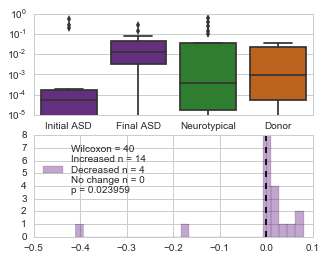

In [8]:
_ = taxonomy_plot(tax_change_df, 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella', multiple_comparisons=False)

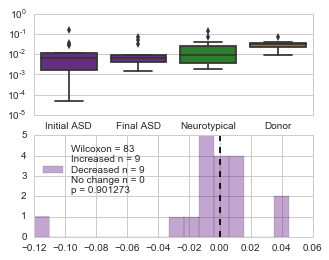

In [9]:
_ = taxonomy_plot(tax_change_df, 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae', multiple_comparisons=False)

/Users/caporaso/miniconda3/envs/autism-fmt/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


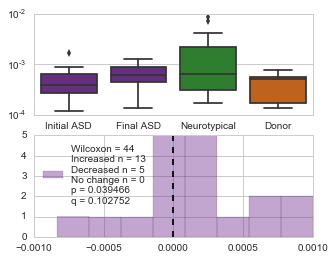

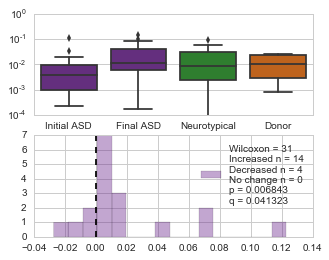

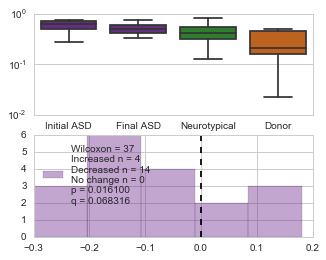

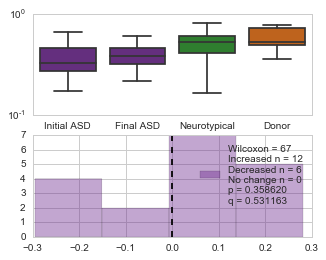

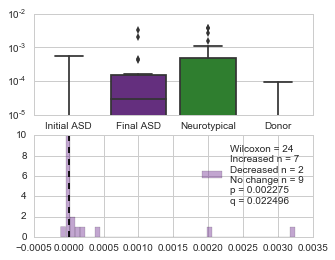

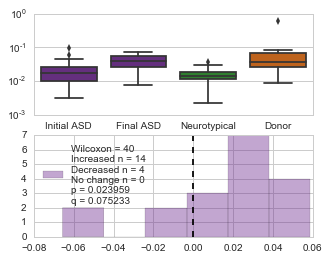

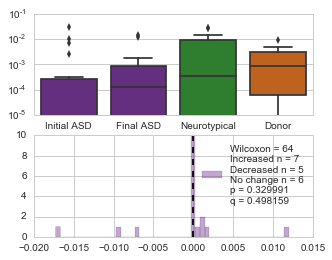

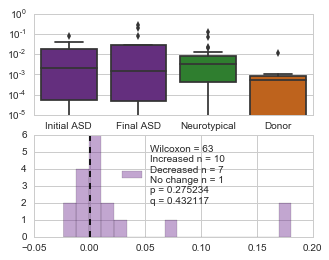

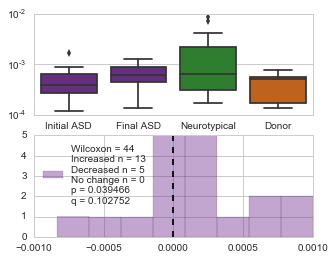

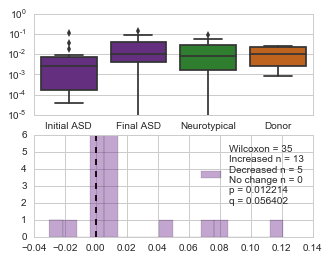

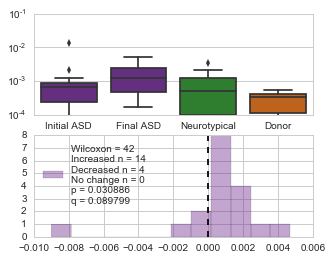

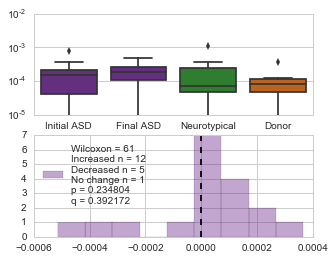

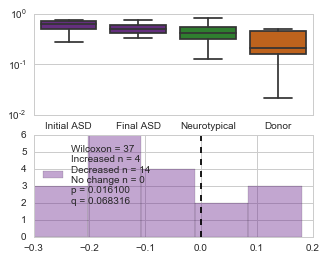

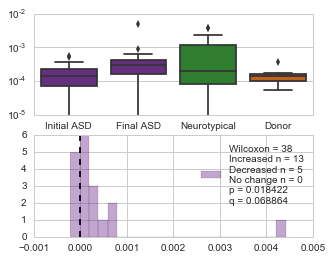

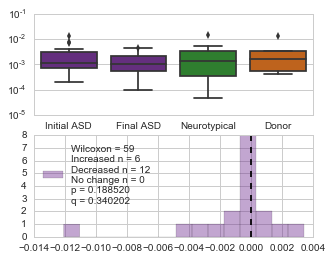

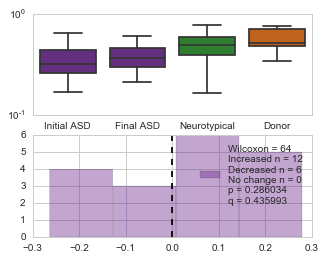

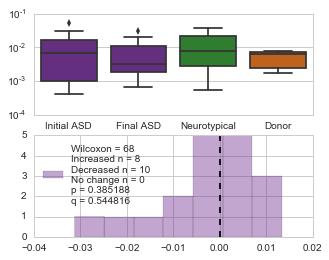

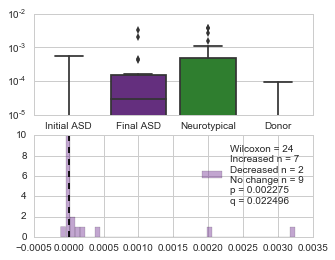

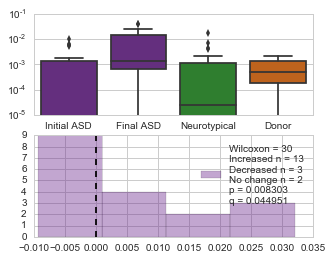

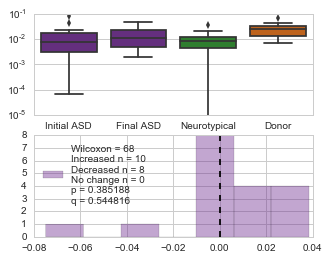

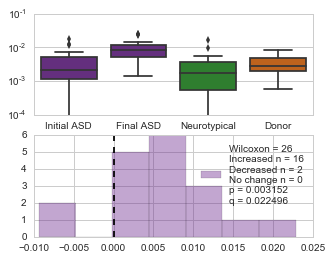

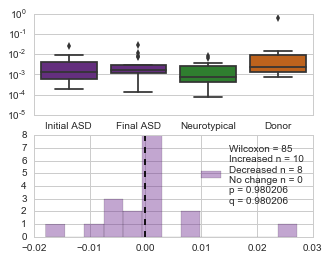

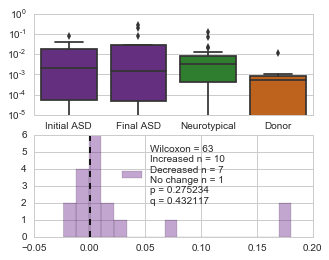

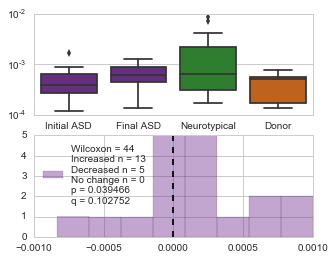

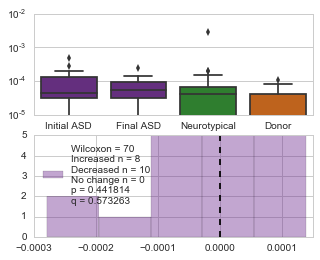

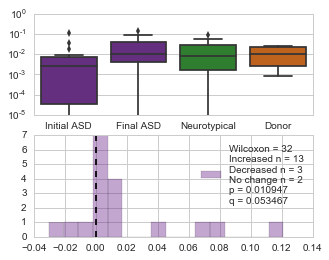

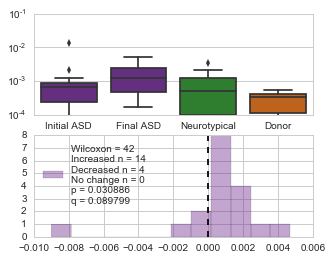

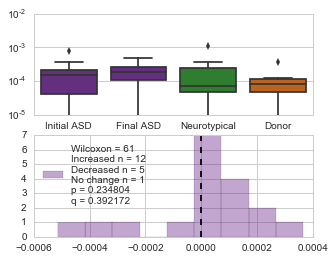

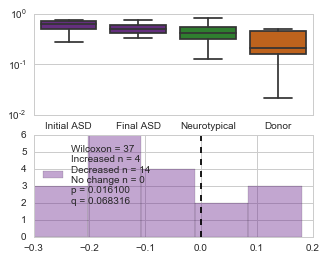

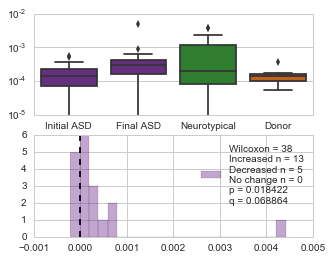

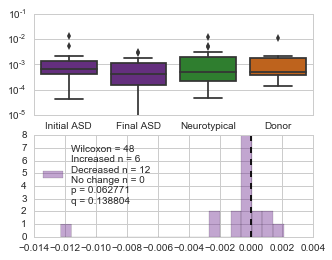

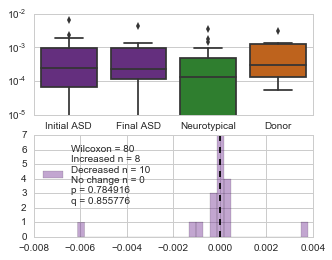

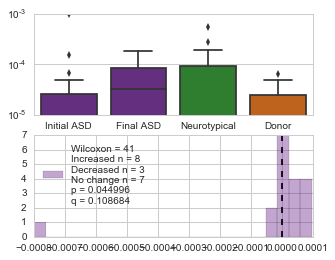

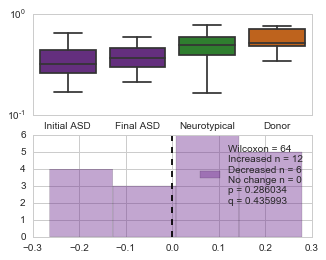

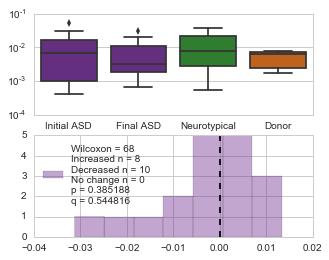

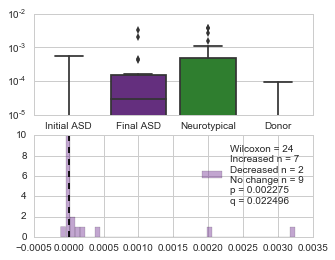

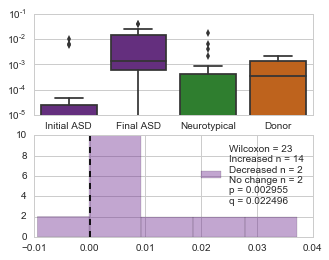

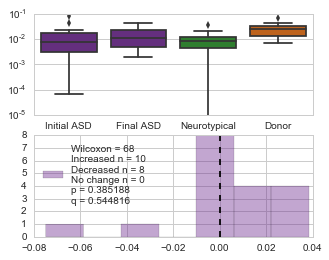

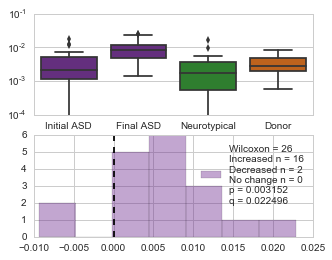

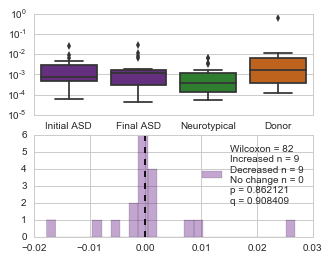

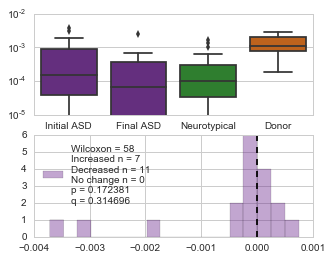

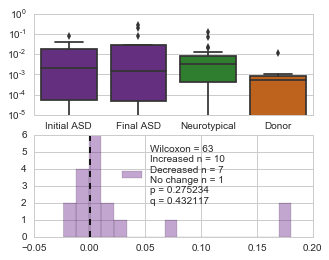

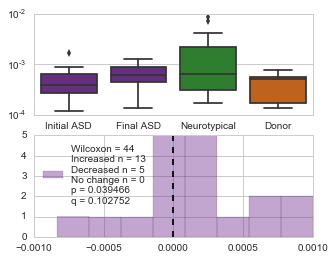

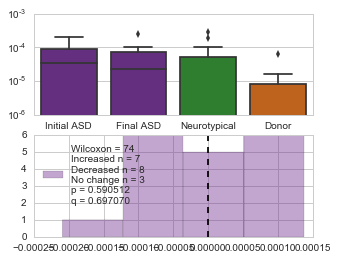

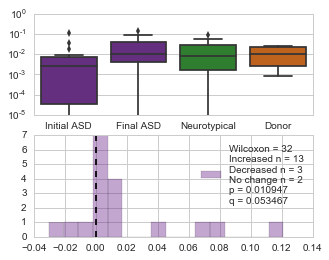

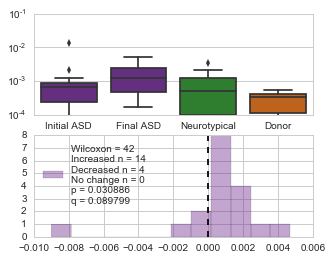

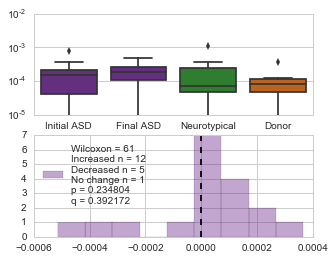

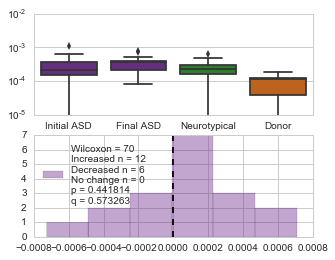

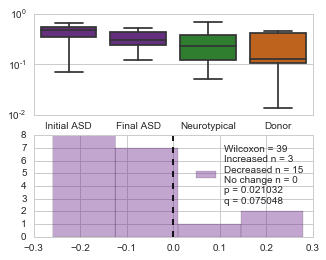

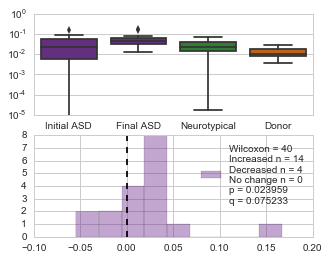

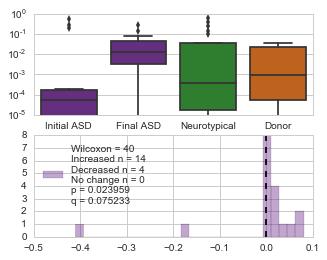

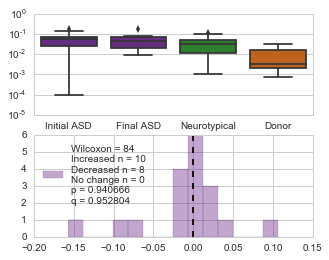

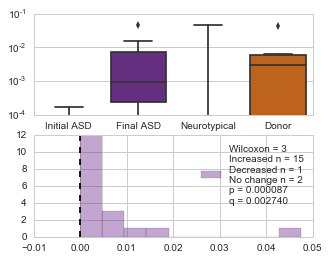

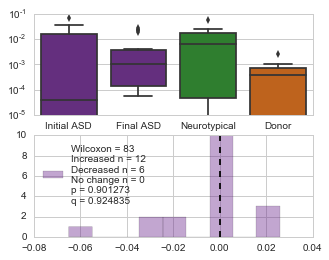

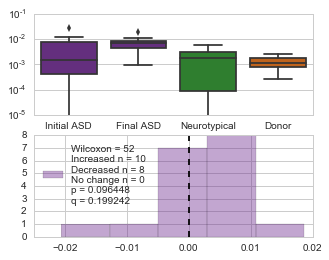

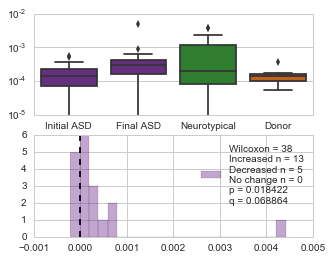

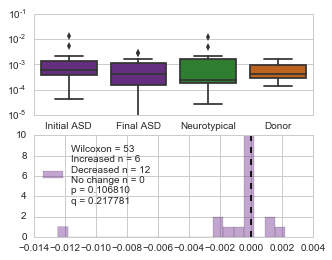

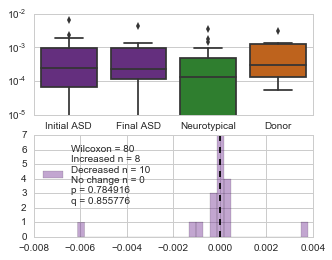

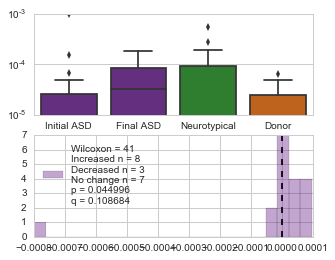

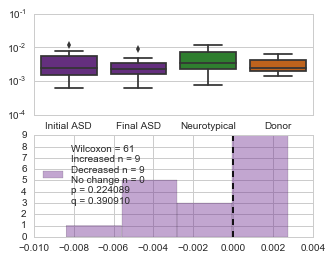

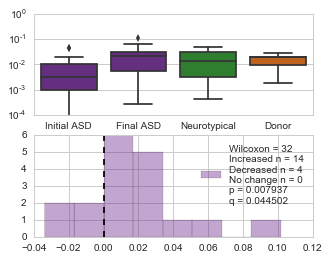

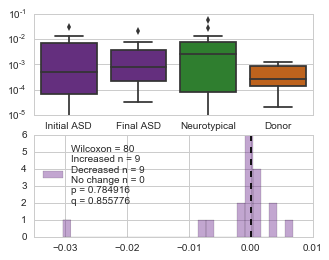

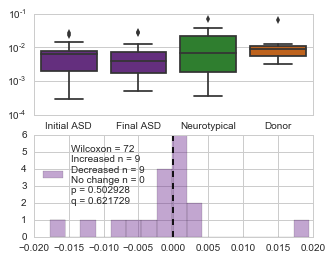

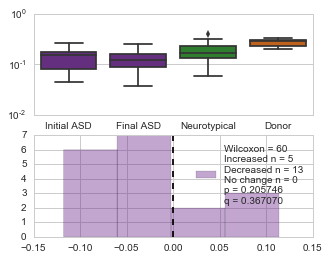

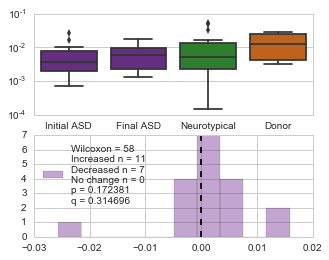

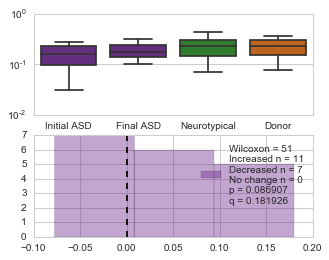

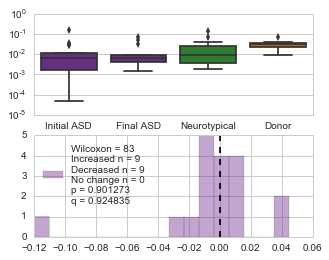

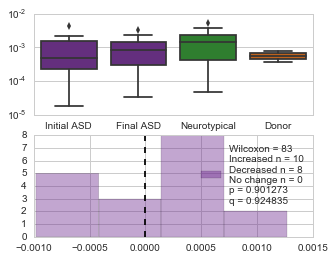

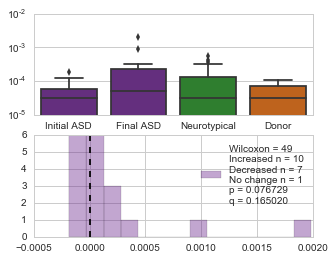

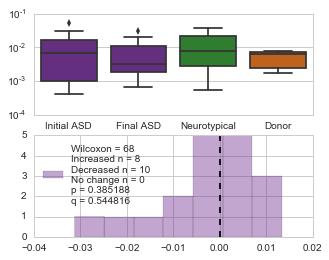

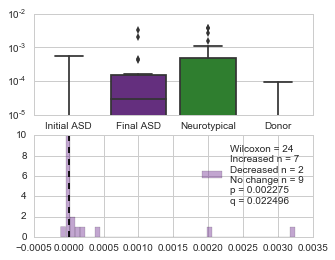

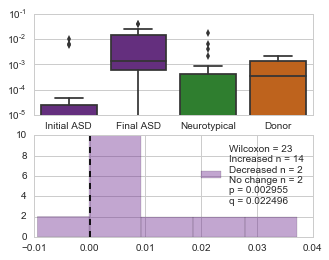

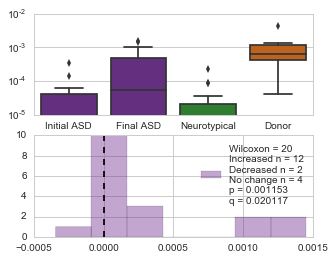

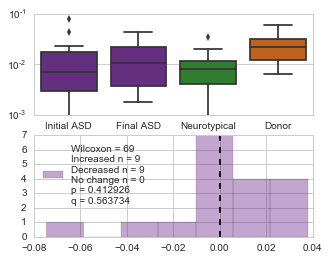

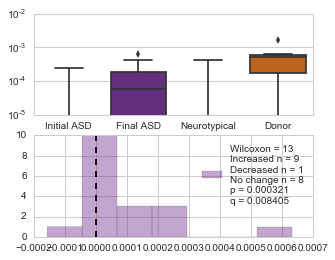

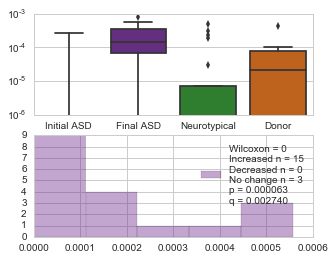

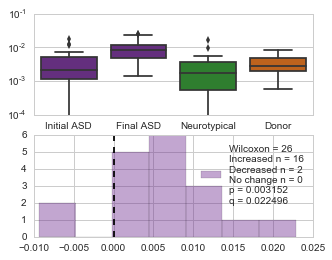

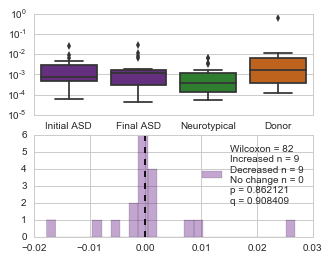

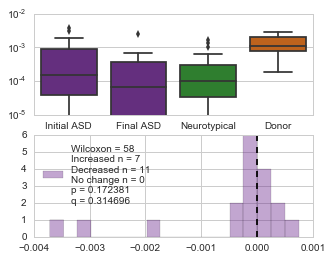

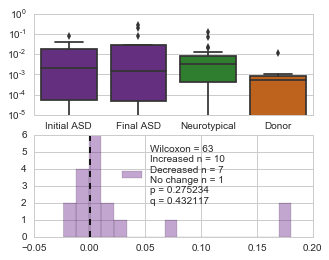

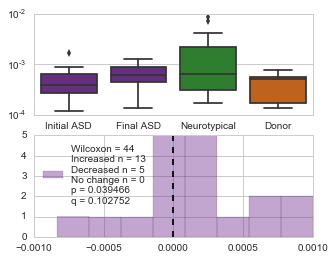

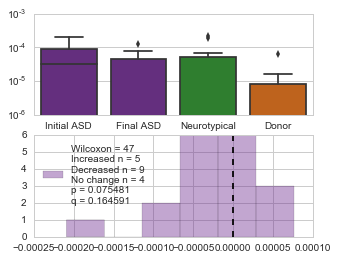

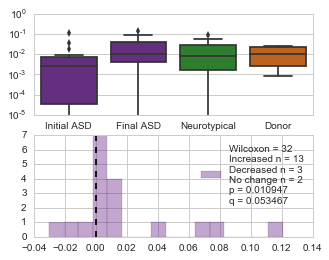

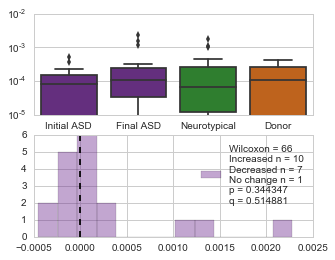

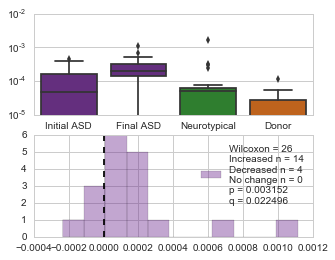

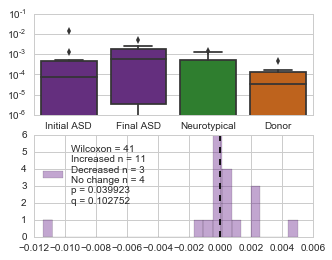

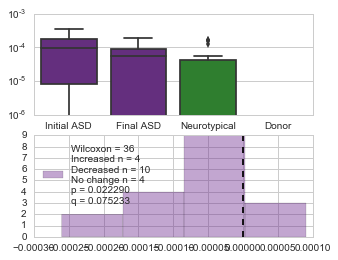

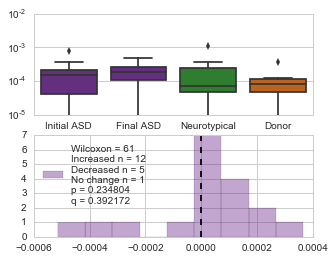

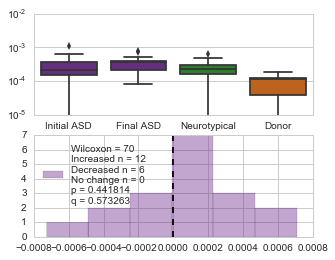

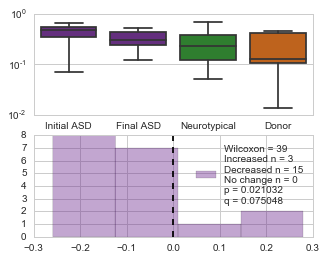

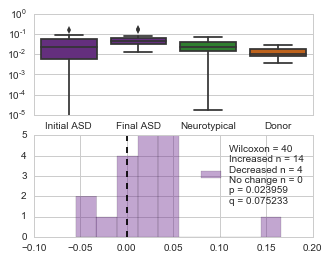

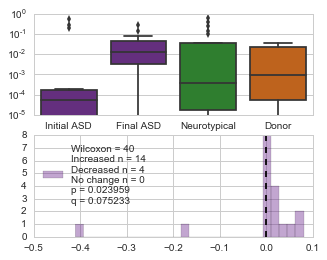

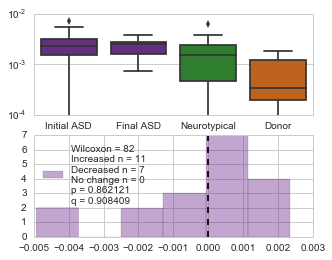

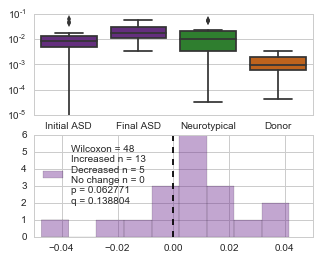

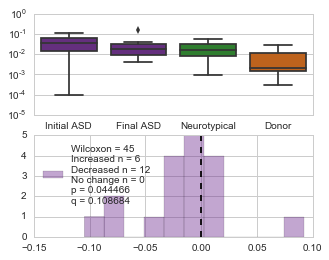

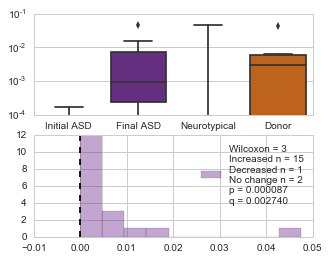

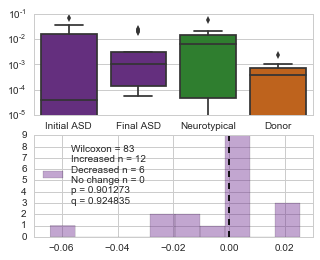

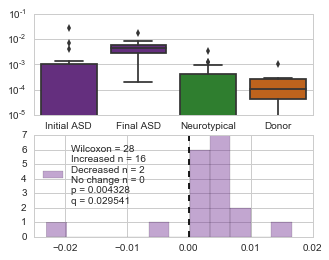

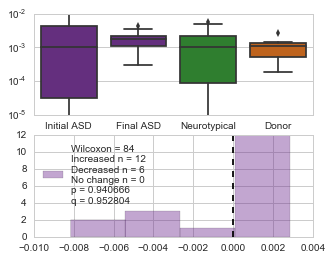

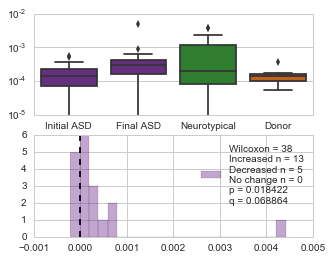

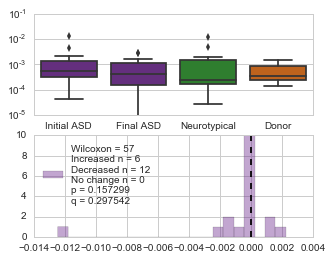

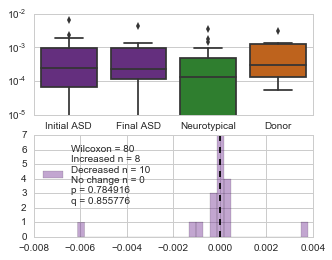

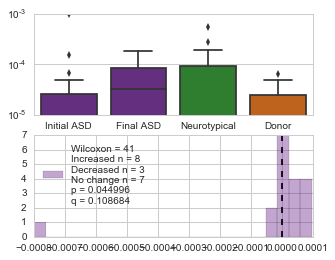

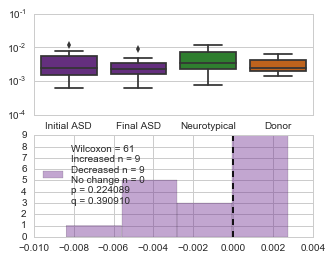

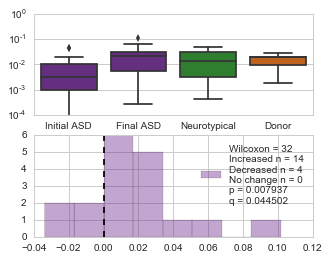

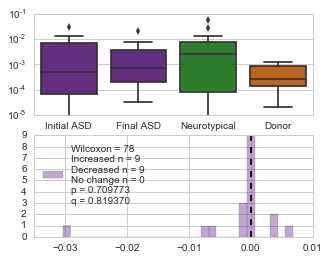

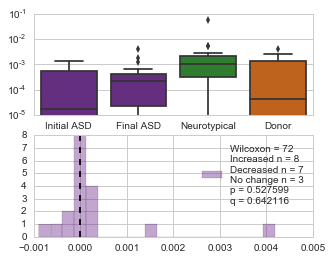

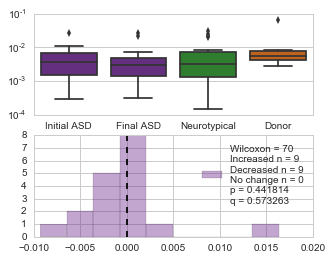

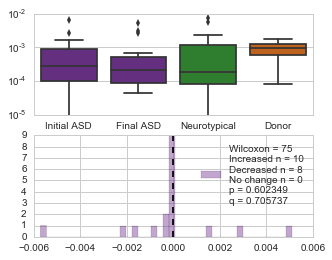

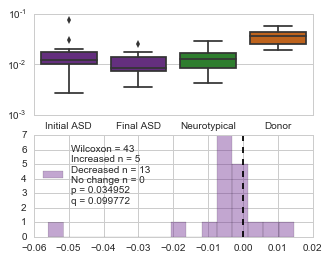

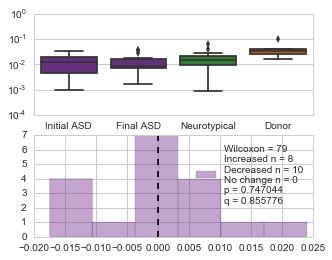

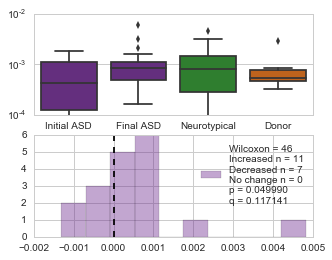

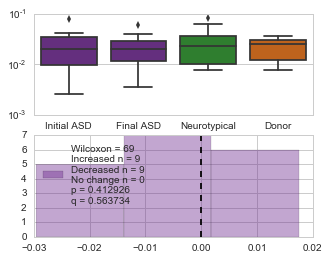

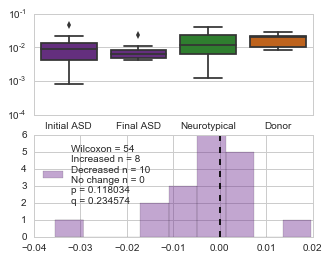

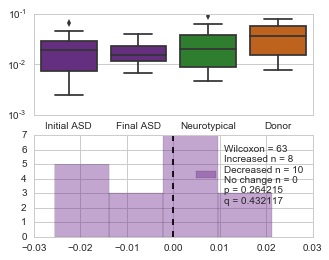

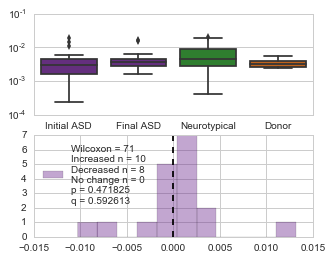

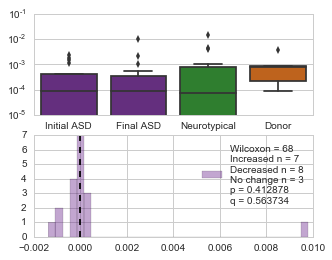

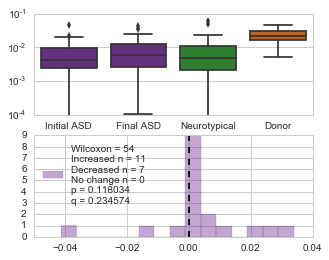

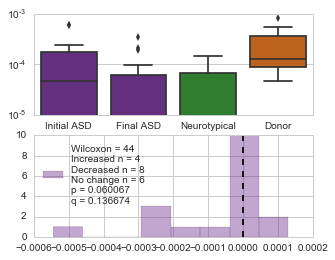

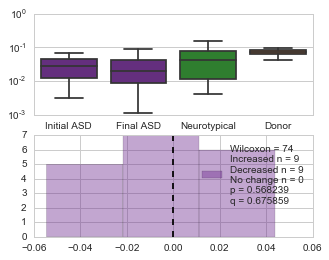

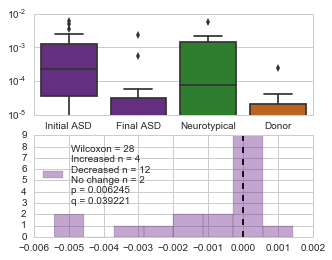

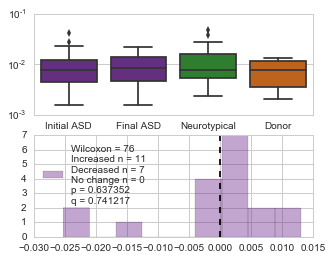

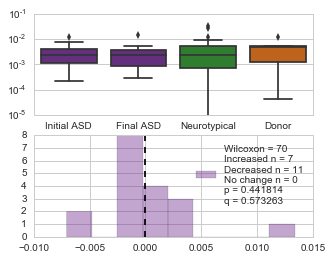

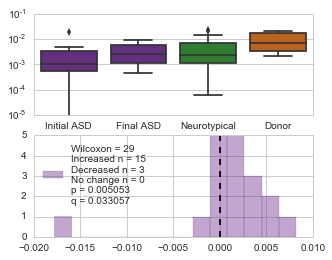

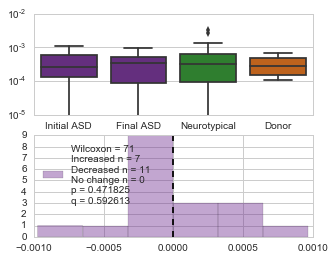

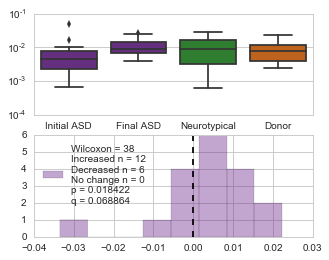

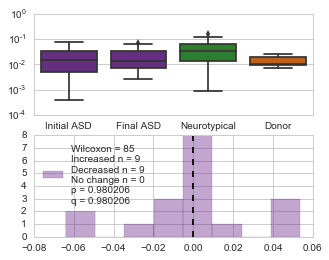

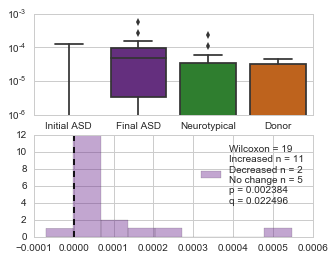

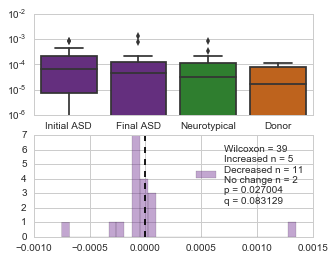

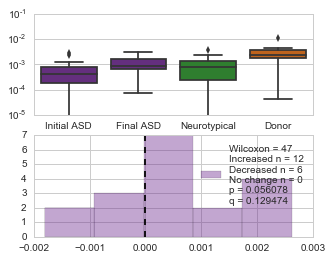

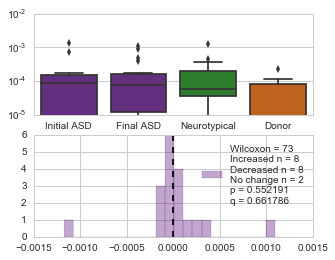

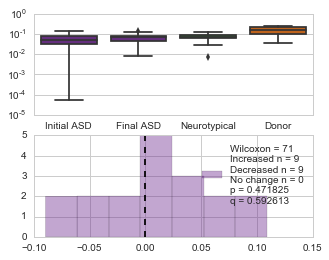

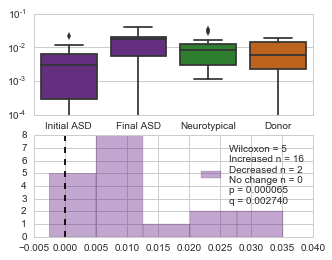

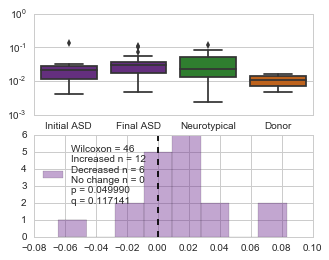

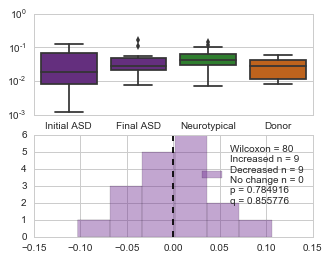

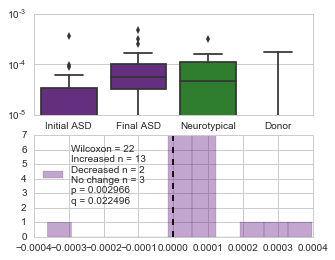

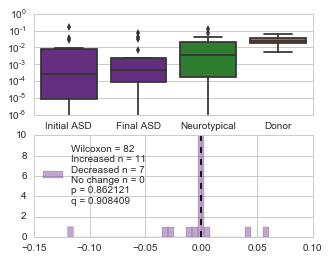

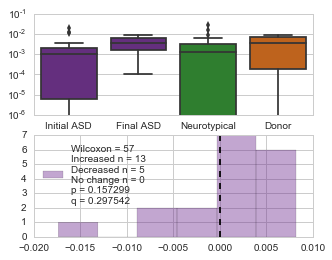

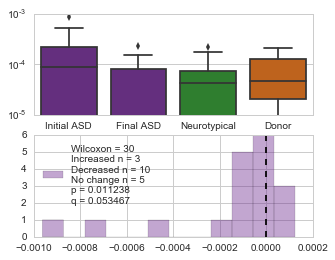

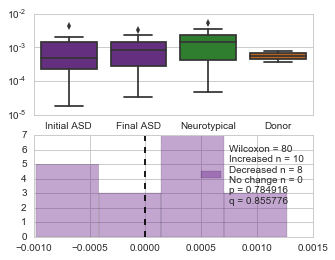

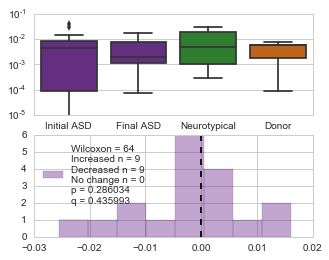

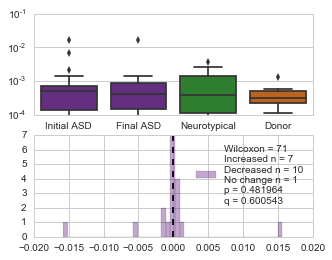

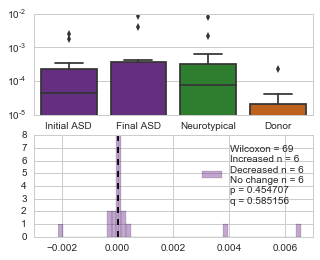

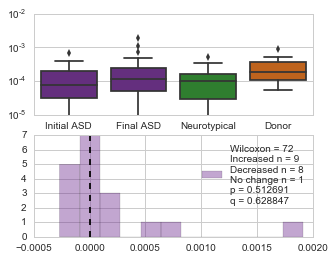

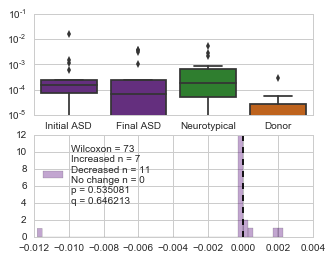

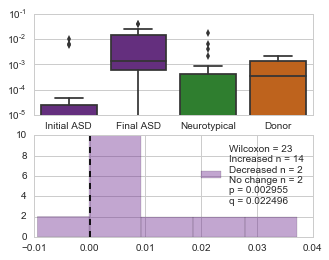

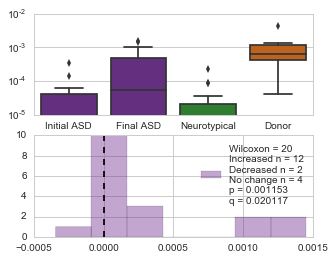

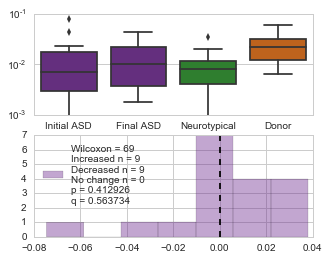

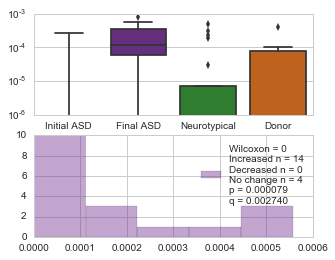

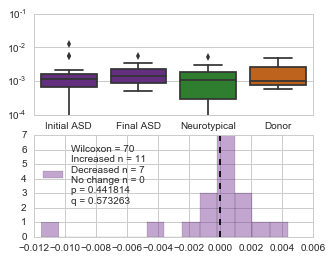

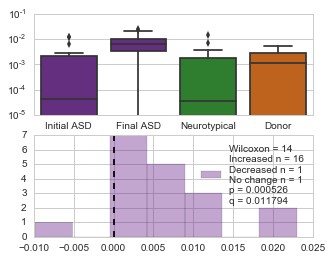

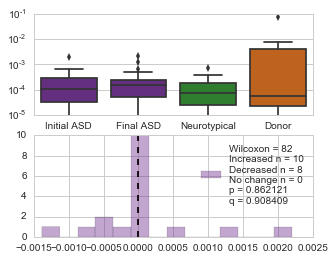

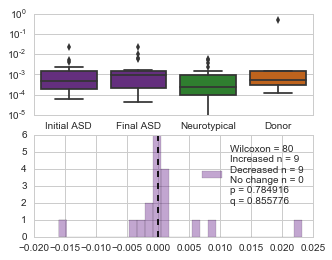

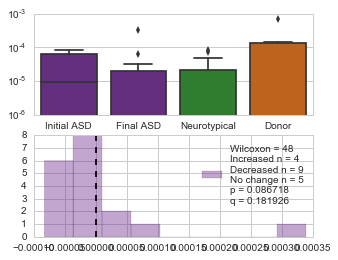

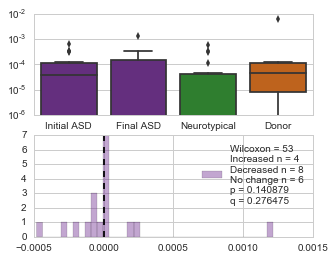

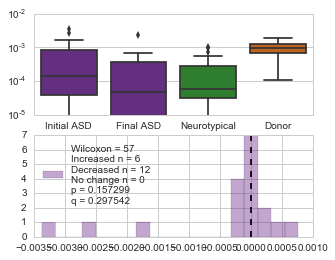

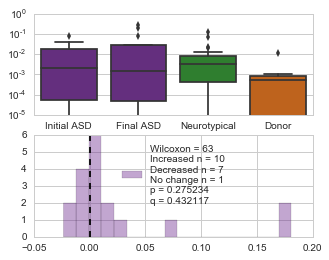

In [10]:
for tax in tax_change_df.index:
    #if tax_engraftment_df['p'][tax] < 0.05:
    _ = taxonomy_plot(tax_change_df, tax)